# Online drift detection for Camelyon17 medical imaging dataset

This notebook demonstrates a typical workflow for applying online drift detectors to streams of image data. For those unfamiliar with how the online drift detectors operate in `alibi_detect` we recommend first checking out the more introductory example [Online Drift Detection on the Wine Quality Dataset](https://docs.seldon.io/projects/alibi-detect/en/stable/examples/cd_online_wine.html) where online drift detection is performed for the wine quality dataset.

This notebook requires the `wilds`, `torch` and `torchvision` packages which can be installed via `pip`:

In [ ]:
!pip install wilds torch torchvision

In [1]:
from typing import Tuple, Generator, Callable, Optional
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from wilds.common.data_loaders import get_train_loader
from wilds import get_dataset

torch.manual_seed(0)
np.random.seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
%matplotlib inline

## Data

We will use the Camelyon17 dataset, one of the [WILDS](https://wilds.stanford.edu/) datasets of [Koh et al, (2020)](https://arxiv.org/abs/2012.07421) that represent "in-the-wild" distribution shifts for various data modalities. It contains tissue scans to be classificatied as benign or cancerous. The pre-change distribution corresponds to scans from across three hospitals and the post-change distribution corresponds to scans from a new fourth hospital.

<div>
<img src=attachment:camelyon.png width="400"/>
</div>

[Koh et al, (2020)](https://arxiv.org/abs/2012.07421) show that models trained on scans from the pre-change distribution achieve an accuracy of 93.2% on unseen scans from same distribution, but only 70.3% accuracy on scans from the post-change distribution.

First we create a function that converts the Camelyon dataset to a stream in order to simulate a live deployment environment. We extract N instances to act as the reference set on which a model of interest was trained. We then consider a stream of images from the pre-change (same) distribution and a stream of images from the post-change (drifted) distribution.


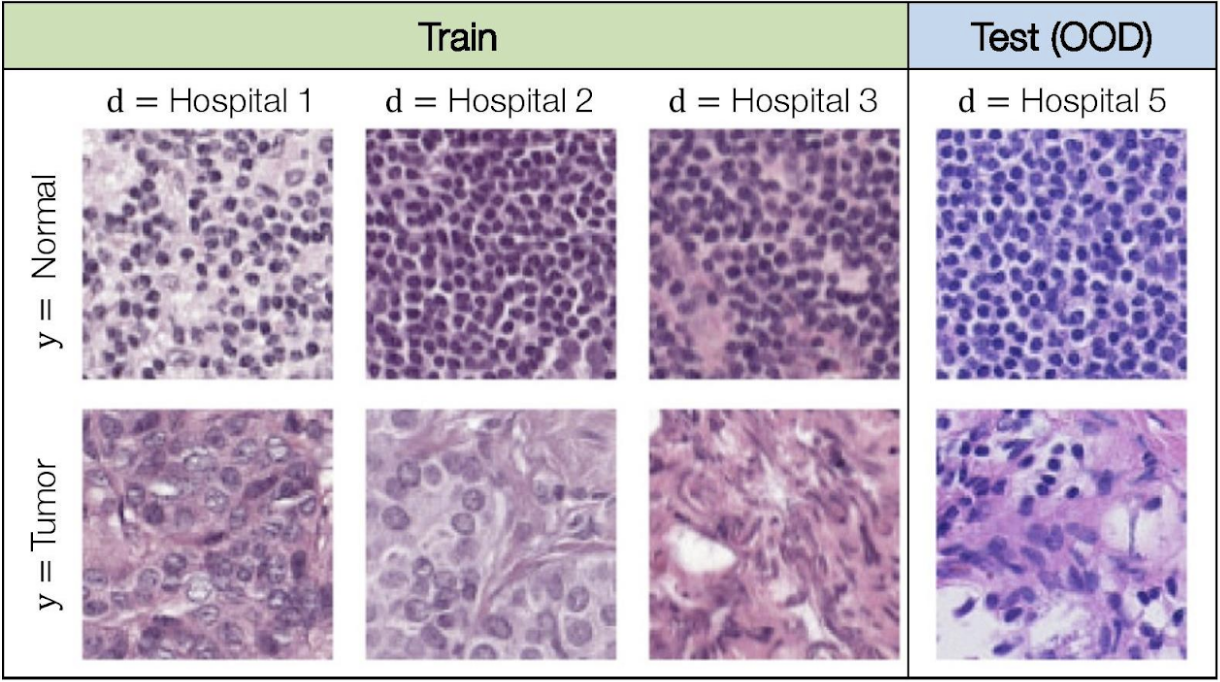

In [2]:
WILDS_PATH = './data/wilds'
DOWNLOAD = False  # set to True for first run
N = 2000  # size of reference set

<div class="alert alert-warning">
The following cell will download the Camelyon dataset (if DOWNLOAD=True). The download size is ~10GB and size on disk is ~15GB.
</div>

In [ ]:
def stream_camelyon(
    split: str='train', 
    img_size: Tuple[int]=(96,96), 
    root_dir: str=None, 
    download: bool=False
) -> Generator:

    camelyon = get_dataset('camelyon17', root_dir=root_dir, download=download)
    ds = camelyon.get_subset(
        split, 
        transform=transforms.Compose([transforms.Resize(img_size), transforms.ToTensor()])
    )
    ds_iter = iter(get_train_loader('standard', ds, batch_size=1))

    while True:
        try:
            img = next(ds_iter)[0][0]
        except Exception:
            ds_iter = iter(get_train_loader('standard', ds, batch_size=1))
            img = next(ds_iter)[0][0]
        yield img.numpy()

stream_p = stream_camelyon(split='train', root_dir=WILDS_PATH, download=DOWNLOAD)
x_ref = np.stack([next(stream_p) for _ in range(N)], axis=0)

stream_q_h0 = stream_camelyon(split='id_val', root_dir=WILDS_PATH, download=DOWNLOAD)
stream_q_h1 = stream_camelyon(split='test', root_dir=WILDS_PATH, download=DOWNLOAD)

Shown below are samples from the pre-change distribution:

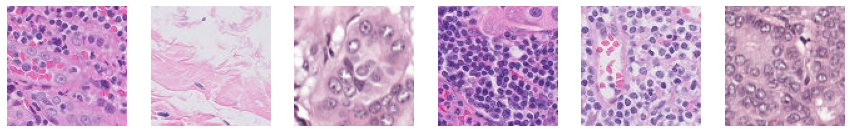

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(15,4))
for i in range(6):
    axs[i].imshow(np.transpose(next(stream_p), (1,2,0)))
    axs[i].axis('off')

And samples from the post-change distribution:

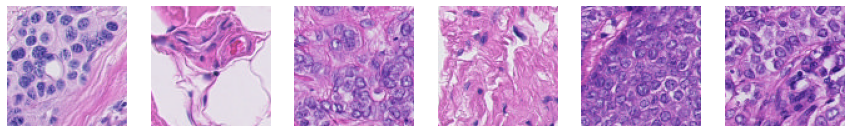

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(15,4))
for i in range(6):
    axs[i].imshow(np.transpose(next(stream_q_h1), (1,2,0)))
    axs[i].axis('off')

## Kernel Projection

The images are of dimension 96x96x3. We train an autoencoder in order to define a more structured representational space of lower dimension. This projection can be thought of as an extension of the kernel. It is important that trained preprocessing components are trained on a split of data that doesn't then form part of the reference data passed to the drift detector.

In [7]:
ENC_DIM = 32
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 1e-3

In [8]:
encoder = nn.Sequential(
    nn.Conv2d(3, 8, 5, stride=3, padding=1),    # [batch, 8, 32, 32]
    nn.ReLU(),
    nn.Conv2d(8, 12, 4, stride=2, padding=1),   # [batch, 12, 16, 16]
    nn.ReLU(),
    nn.Conv2d(12, 16, 4, stride=2, padding=1),   # [batch, 16, 8, 8]
    nn.ReLU(),
    nn.Conv2d(16, 20, 4, stride=2, padding=1),   # [batch, 20, 4, 4]
    nn.ReLU(),
    nn.Conv2d(20, ENC_DIM, 4, stride=1, padding=0),   # [batch, enc_dim, 1, 1]
    nn.Flatten(), 
)
decoder = nn.Sequential(
    nn.Unflatten(1, (ENC_DIM, 1, 1)),
    nn.ConvTranspose2d(ENC_DIM, 20, 4, stride=1, padding=0),  # [batch, 20, 4, 4]
    nn.ReLU(),
    nn.ConvTranspose2d(20, 16, 4, stride=2, padding=1),  # [batch, 16, 8, 8]
    nn.ReLU(),
    nn.ConvTranspose2d(16, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
    nn.ReLU(),
    nn.ConvTranspose2d(12, 8, 4, stride=2, padding=1),  # [batch, 8, 32, 32]
    nn.ReLU(),
    nn.ConvTranspose2d(8, 3, 5, stride=3, padding=1),   # [batch, 3, 96, 96]
    nn.Sigmoid(),
)
ae = nn.Sequential(encoder, decoder).to(device)

x_fit, x_ref = np.split(x_ref, [len(x_ref)//2])
x_fit = torch.as_tensor(x_fit)
x_fit_dl = DataLoader(TensorDataset(x_fit, x_fit), BATCH_SIZE, shuffle=True)

We can train the autoencoder using a helper function provided for convenience in `alibi-detect`.

In [9]:
from alibi_detect.models.pytorch import trainer

trainer(ae, nn.MSELoss(), x_fit_dl, device, learning_rate=LEARNING_RATE, epochs=EPOCHS)

2021-08-13 15:13:11.305800: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Epoch 5/5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 128.28it/s, loss=0.0164]


The preprocessing/projection functions are expected to map numpy arrays to numpy array, so we wrap the encoder within the function below.

In [10]:
def encoder_fn(x: np.ndarray) -> np.ndarray:
    x = torch.as_tensor(x).to(device)
    with torch.no_grad():
        x_proj = encoder(x)
    return x_proj.cpu().numpy()

## Drift Detection

`alibi-detect`'s online drift detectors window the stream of data in an 'overlapping window' manner such that a test is performed at every time step. We will use an estimator of MMD as the test statistic. The estimate is updated incrementally at low cost. The thresholds are configured via simulation in an initial configuration phase to target the desired expected runtime (ERT) in the absence of change. For a detailed description of this calibration procedure see [Cobb et al, 2021](https://arxiv.org/abs/2108.00883).

In [11]:
ERT = 150  # expected run-time in absence of change
W = 20  # size of test window
B = 50_000  # number of simulations to configure threshold

In [12]:
from alibi_detect.cd import MMDDriftOnline

dd = MMDDriftOnline(x_ref, ERT, W, backend='pytorch', preprocess_fn=encoder_fn)

Generating permutations of kernel matrix..


Computing thresholds: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.70it/s]


We define a function which will apply the detector to the streams and return the time at which drift was detected.

In [13]:
def compute_runtime(detector: Callable, stream: Generator) -> int:

    t = 0
    detector.reset_state()
    detected = False

    while not detected:
        t += 1
        z = next(stream)
        pred = detector.predict(z)
        detected = pred['data']['is_drift']
    print(t)
    return t

First we apply the detector multiple times to the pre-change stream where the distribution is unchanged.

In [14]:
times_h0 = [compute_runtime(dd, stream_p) for i in range(15)]
print(f"Average runtime in absence of change: {np.array(times_h0).mean()}")

575
134
328
35
28
166
79
158
33
298
54
122
28
216
80
Average runtime in absence of change: 155.6


We see that the average runtime in the absence of change is close to the desired ERT, as expected. We can inspect the detector's `test_stats` and `thresholds` properties to see how the test statistic varied over time and how close it got to exceeding the threshold.

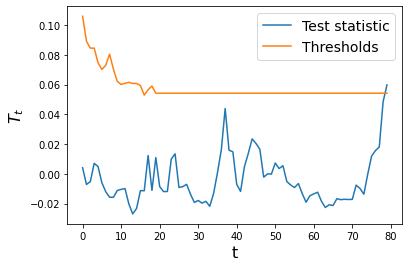

In [15]:
ts = np.arange(dd.t)
plt.plot(ts, dd.test_stats, label='Test statistic')
plt.plot(ts, dd.thresholds, label='Thresholds')
plt.xlabel('t', fontsize=16)
plt.ylabel('$T_t$', fontsize=16)
plt.legend(loc='upper right', fontsize=14)
plt.show()

Now we apply it to the post-change stream where the images are from a drifted distribution.

In [16]:
times_h1 = [compute_runtime(dd, stream_q_h1) for i in range(15)]
print(f"Average detection delay following change: {np.array(times_h1).mean()}")

15
17
12
20
5
15
12
12
20
9
11
6
12
14
11
Average detection delay following change: 12.733333333333333


We see that the detector is quick to flag drift when it has occured.

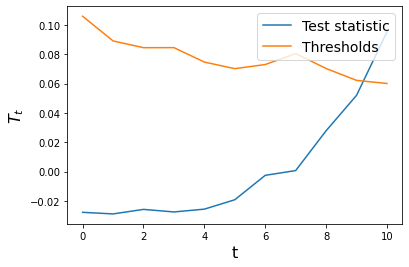

In [17]:
ts = np.arange(dd.t)
plt.plot(ts, dd.test_stats, label='Test statistic')
plt.plot(ts, dd.thresholds, label='Thresholds')
plt.xlabel('t', fontsize=16)
plt.ylabel('$T_t$', fontsize=16)
plt.legend(loc='upper right', fontsize=14)
plt.show()